### mnist-keras

In [1]:
from keras import layers, models

class AE(models.Model):
    # x_nodes 입력노드수, z_dim 은닉노드수
    # 24x24(픽셀 784개) 입력 이미지들이 원소 36개로 구성된 벡터로 변환된 뒤
    #     24x24 이미지로 복구됨

    def __init__(self, x_nodes=784, z_dim=36):
        x_shape = (x_nodes,)

        #입력 계층
        x = layers.Input(shape=x_shape)

        #은닉 계층
        z = layers.Dense(z_dim, activation='relu')(x)

        #출력 계층
        y = layers.Dense(x_nodes, activation='sigmoid')(z)

        super().__init__(x, y)

        self.x = x
        self.z = z

        self.z_dim = z_dim     

        self.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    #신경망 외부에서 부호화 결과를 확인하고 싶을 때 호출할 함수
    def Encoder(self):
        return models.Model(self.x, self.z)

    #복호화를 수행하는 함수
    def Decoder(self):
        z_shape = (self.z_dim,)
        z = layers.Input(shape=z_shape)

        # 제일 마지막 레이어가 출력 계층
        y_layer = self.layers[-1]
        y = y_layer(z)

        return models.Model(z, y)

In [2]:
from keras.datasets import mnist
import numpy as np

# 데이터 로딩

# 레이블 정보는 _로 전달받음, 추후 사용되지 않는
#         함수의 리턴값을 받는 변수는 밑줄 _ 사용을 권장함

# AE는 비지도학습이기에 레이블을 필요로 하지 않음

# 입력데이터를 출력데이터에 똑같이 사용함

(X_train, _), (X_test, _) = mnist.load_data()

#입력값이 1 이하가 되도록 정규화시킴

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

print(X_train.shape)

(60000, 28, 28)


In [3]:
#3차원에서 2차원 형태로 모양을 바꿈(차원 축소)

# len(X_train) 이미지수, np.prod(X_train.shape[1:]) 이미지 길이

#print(X_train.shape[1:]) #(28,28)

X_train = X_train.reshape(len(X_train), 784)
X_test = X_test.reshape(len(X_test), 784)

print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


In [5]:
import tensorflow as tf
with tf.device('/:GPU0'):
    #파라미터 설정(입력노드수 784, 부호화 벡터 길이 36 -
    #        길이가 784인 원래 이미지의 데이터 길이가 36으로 압축됨)
    x_nodes = 784
    z_dim = 36

    #모델 생성
    autoencoder = AE(x_nodes, z_dim)

    #모델 학습
    #입력데이터와 출력데이터를 동일하게 설정

    # fit(입력데이터,출력데이터)
    history = autoencoder.fit(X_train, X_train,
                              epochs=5,
                              batch_size=256,
                              validation_split=0.2)

Epoch 1/5
188/188 [==============================] - 2s 6ms/step - loss: 0.2893 - accuracy: 0.0122 - val_loss: 0.1985 - val_accuracy: 0.0132
Epoch 2/5
188/188 [==============================] - 1s 5ms/step - loss: 0.1773 - accuracy: 0.0111 - val_loss: 0.1610 - val_accuracy: 0.0141
Epoch 3/5
188/188 [==============================] - 1s 5ms/step - loss: 0.1509 - accuracy: 0.0104 - val_loss: 0.1412 - val_accuracy: 0.0113
Epoch 4/5
188/188 [==============================] - 1s 5ms/step - loss: 0.1339 - accuracy: 0.0103 - val_loss: 0.1270 - val_accuracy: 0.0092
Epoch 5/5
188/188 [==============================] - 1s 5ms/step - loss: 0.1220 - accuracy: 0.0103 - val_loss: 0.1172 - val_accuracy: 0.0100


In [6]:
def plot_acc(history, title=None):
    if not isinstance(history,dict):
        history=history.history

    plt.plot(history["accuracy"])
    plt.plot(history["val_accuracy"])

    if title is not None:
        plt.title(title)

    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["Train","Test"],loc=0)

In [7]:
def plot_loss(history,title=None):
    if not isinstance(history,dict):
        history=history.history

    plt.plot(history["loss"])
    plt.plot(history["val_loss"])

    if title is not None:
        plt.title(title)

    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["Train","Test"],loc=0)

In [8]:
def plot_loss_acc(history):
    plot_loss(history,"Loss")
    plt.show()

    plot_acc(history,"Accuracy")
    plt.show()   

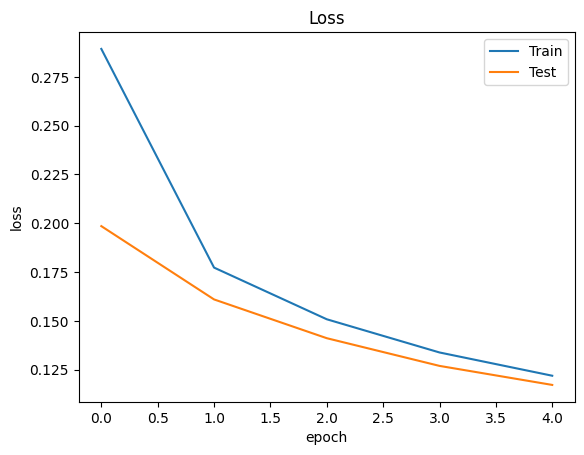

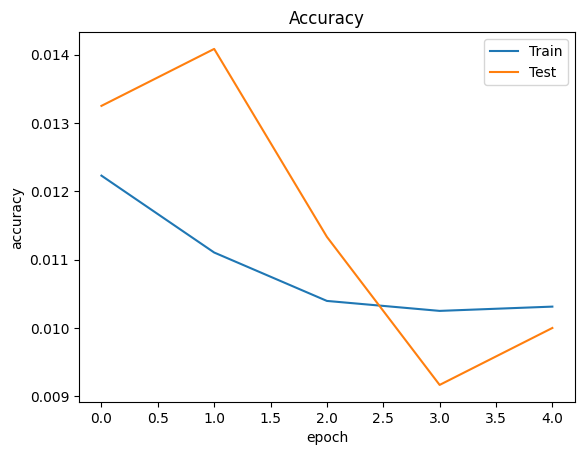

In [9]:
import matplotlib.pyplot as plt

plot_loss_acc(history)

In [11]:
def show_ae(autoencoder):

    encoder = autoencoder.Encoder()     # 784 => 36
    decoder = autoencoder.Decoder()     # 36 => 784

    encoder.summary()
    decoder.summary()

    #평가용 이미지들을 넣어서 부호화 결과와 복호화 결과 생성
    encoded_imgs = encoder.predict(X_test)

    #부호화된 이미지를 넣어서 복호화 데이터를 생성함
    decoded_imgs = decoder.predict(encoded_imgs)

    #화면에 표시할 이미지의 수
    n = 10

    plt.figure(figsize=(20, 6))

    for i in range(n):
        ax = plt.subplot(3, n, i + 1)

        #입력 이미지(평가용 이미지)
        plt.imshow(X_test[i].reshape(28, 28))

        #흑백으로 출력
        plt.gray()

        #이미지 주변 축들이 보이지 않게 함
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n)

        #이미지가 압축된 형태(2차원 이미지를 1차원의 벡터로 압축)
        plt.stem(encoded_imgs[i].reshape(-1))
        plt.gray()

        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n + n)

        #복호화한 이미지 출력
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()

        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_2 (Dense)             (None, 36)                28260     
                                                                 
Total params: 28,260
Trainable params: 28,260
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 36)]              0         
                                                                 
 dense_3 (Dense)             (None, 784)               29008     
                                                                 
Total params: 29,008
Trainable params: 2

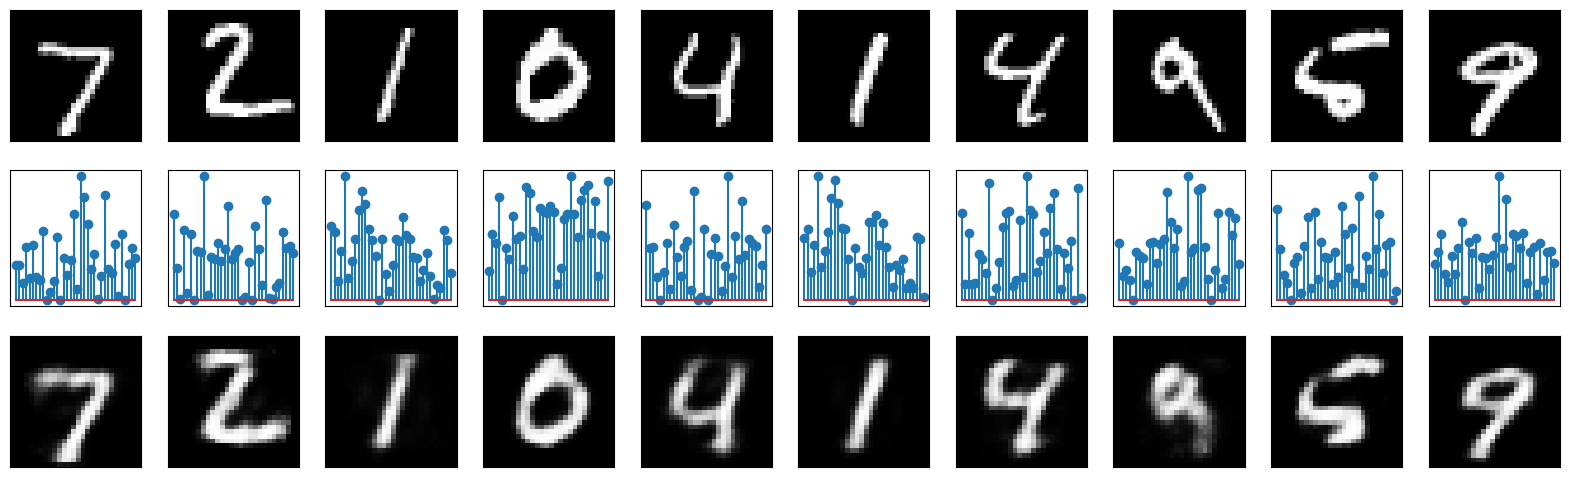

In [12]:
show_ae(autoencoder)